In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
YEAR = 2018
YEAR_STRING = "2018"

In [3]:
df_ghg = pd.read_csv("./Data/UK_LA_GHG_EMISSIONS.csv")
df_gdp = pd.read_csv("./Data/GDP_by_LA.csv", skiprows=1, thousands=",")
df_traffic = pd.read_csv("./Data/local_authority_traffic.csv")

df_cities = pd.read_csv("./../01_LocalAuthorities/lauth-classification-csv.csv")
df_cities["classification"] = df_cities["classification"].str.capitalize()
df_cities = df_cities[["localauth_code", "classification", 'percent_of_localauth']]
df_cities = df_cities.pivot(index="localauth_code", columns="classification", values="percent_of_localauth")
df_cities = df_cities.where(pd.notna(df_cities), 0)

In [4]:
ghg_condition1 = (df_ghg["Calendar Year"] == YEAR)
ghg_condition2 = (df_ghg["LA GHG Sub-sector"] == "Road Transport (A roads)")
ghg_condition3 = (df_ghg["Greenhouse gas"] == "CO2")

df_ghg = df_ghg[ghg_condition1 & ghg_condition2 & ghg_condition3]

In [5]:
traffic_condition1 = (df_traffic["year"] == YEAR)

df_traffic = df_traffic[traffic_condition1]

In [6]:
df_urban_population = pd.DataFrame(data={
    "LA Code": df_cities.index,
    "Urban Population": df_cities["Core city (london)"] + df_cities["Core city (outside london)"] + df_cities["Other city"]
})

In [7]:
df_merged = df_urban_population.merge(df_ghg, how="inner", left_on="LA Code", right_on="Local Authority Code")
df_merged = df_merged.merge(df_gdp, how="inner", left_on="LA Code", right_on="LA code")
df_merged = df_merged.merge(df_traffic, how="inner", left_on="LA Code", right_on="ONS_code")

In [8]:
df_merged_relevant = df_merged[["LA Code", "Territorial emissions (kt CO2e)", "Mid-year Population (thousands)", "Area (km2)", YEAR_STRING, "link_length_km", "all_motor_vehicles"]]
df_merged_relevant

,LA Code,Territorial emissions (kt CO2e),Mid-year Population (thousands),Area (km2),2018,link_length_km,all_motor_vehicles
0,E06000001,80.361007,93.242,98.3466,1645,407.9089,3.970277e+08
1,E06000002,139.265529,140.545,54.5537,3405,529.7030,7.421440e+08
2,E06000003,98.695688,136.718,253.7857,2123,684.6929,5.810374e+08
3,E06000004,212.866413,197.213,209.7309,5521,883.7523,8.823905e+08
4,E06000005,70.917002,106.566,197.4758,2878,552.5404,5.116976e+08
...,...,...,...,...,...,...,...
168,W06000020,61.122965,93.049,126.2401,1888,478.7708,4.199331e+08
169,W06000021,162.610136,94.142,886.0557,2292,1625.5685,9.379984e+08
170,W06000022,91.974974,153.302,217.4554,4550,750.9468,1.251067e+09
171,W06000023,210.689468,132.447,5195.4561,2658,5367.8299,1.050016e+09


In [24]:
reg = LinearRegression().fit(df_merged_relevant[["Mid-year Population (thousands)", YEAR_STRING, "Area (km2)", 'link_length_km']], df_merged_relevant["Territorial emissions (kt CO2e)"])

reg.score(df_merged_relevant[["Mid-year Population (thousands)", YEAR_STRING, "Area (km2)", 'link_length_km']], df_merged_relevant["Territorial emissions (kt CO2e)"])

0.8038952519703846

In [31]:
codes = ['W06000019', 'E06000053', 'E06000036', 'E08000008', 'W06000024',
       'E08000002', 'E08000023', 'E08000006', 'E06000043', 'E08000030',
       'E08000028', 'E06000027', 'E08000009', 'E08000027', 'E06000018',
       'E08000022', 'E09000008', 'E08000021']
accuracies = []
for index in codes:
    tmp = df_merged_relevant[df_merged_relevant["LA Code"] == index]
    prediction = reg.predict(tmp[["Mid-year Population (thousands)", YEAR_STRING, "Area (km2)", 'link_length_km']])
    accuracy = 100*prediction[0]/tmp["Territorial emissions (kt CO2e)"].values[0]
    #print(index, "\tPREDICTION: ", prediction, "\tACTUAL: ", tmp["Territorial emissions (kt CO2e)"].values[0])
    print(index, "\tAccuracy: ", accuracy)
    if(accuracy < 200) : accuracies.append(prediction[0]/tmp["Territorial emissions (kt CO2e)"].values[0])

W06000019 	Accuracy:  118.7940637420308
E06000053 	Accuracy:  4827.113196790135
E06000036 	Accuracy:  109.74157502663853
E08000008 	Accuracy:  144.16223545281093
W06000024 	Accuracy:  85.91606776794134
E08000002 	Accuracy:  139.7609395151096
E08000023 	Accuracy:  95.98572354542058
E08000006 	Accuracy:  95.5331948442962
E06000043 	Accuracy:  97.63515251335421
E08000030 	Accuracy:  119.92226759675528
E08000028 	Accuracy:  106.08013471629037
E06000027 	Accuracy:  141.28760537047222
E08000009 	Accuracy:  148.8477290073902
E08000027 	Accuracy:  114.78750461322868
E06000018 	Accuracy:  89.28568207056279
E08000022 	Accuracy:  83.1071476734769
E09000008 	Accuracy:  116.93351647770353
E08000021 	Accuracy:  82.19958910326436


In [39]:
[round(num, 3) for num in accuracies]

[1.188,
 1.097,
 1.442,
 0.859,
 1.398,
 0.96,
 0.955,
 0.976,
 1.199,
 1.061,
 1.413,
 1.488,
 1.148,
 0.893,
 0.831,
 1.169,
 0.822]

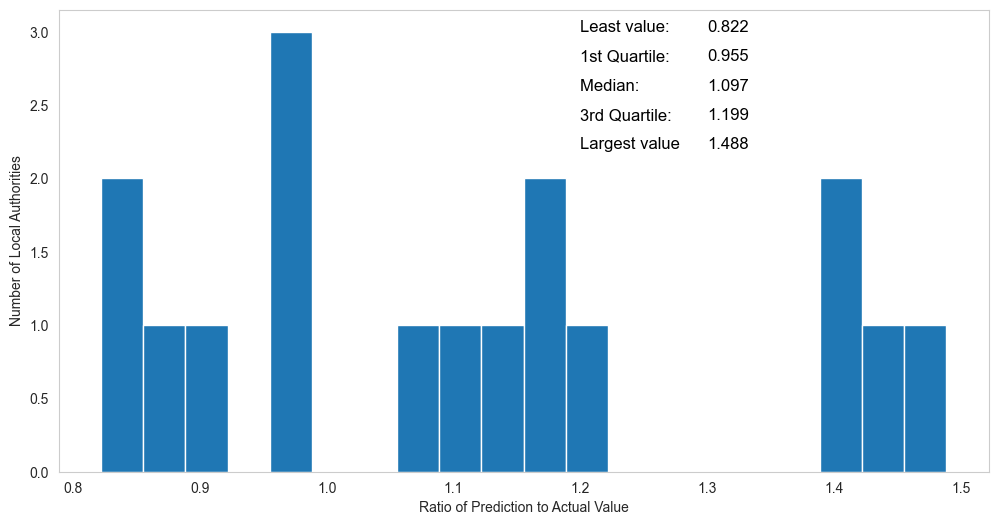

In [62]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(1, figsize=(12, 6))
ax = fig.add_subplot(111)

ax.hist(accuracies, bins=20)
ax.set_xlabel("Ratio of Prediction to Actual Value")
ax.set_ylabel("Number of Local Authorities")

quantiles = np.quantile(accuracies, np.array([0.00, 0.25, 0.50, 0.75, 1.00]))
ax.vlines(quantiles, [0] * quantiles.size, [1] * quantiles.size,
          color='b', ls=':', lw=0.5, zorder=0)

ax.text(1.2, 3, "Least value: ", {'color': '00', 'fontsize': 12})
ax.text(1.3, 3, round(quantiles[0],3), {'color': '00', 'fontsize': 12})
ax.text(1.2, 2.8, "1st Quartile: ", {'color': '00', 'fontsize': 12})
ax.text(1.3, 2.8, round(quantiles[1],3), {'color': '00', 'fontsize': 12})
ax.text(1.2, 2.6, "Median: ", {'color': '00', 'fontsize': 12})
ax.text(1.3, 2.6, round(quantiles[2], 3), {'color': '00', 'fontsize': 12})
ax.text(1.2, 2.4, "3rd Quartile: ", {'color': '00', 'fontsize': 12})
ax.text(1.3, 2.4, round(quantiles[3],3), {'color': '00', 'fontsize': 12})
ax.text(1.2, 2.2, "Largest value ", {'color': '00', 'fontsize': 12})
ax.text(1.3, 2.2, round(quantiles[4],3), {'color': '00', 'fontsize': 12})
ax.grid(False)
plt.show()

In [12]:
df_merged_relevant[df_merged_relevant["LA Code"] == "E06000043"]

,LA Code,Territorial emissions (kt CO2e),Mid-year Population (thousands),Area (km2),2018,link_length_km,all_motor_vehicles
40,E06000043,144.452832,290.395,85.386,9285,621.1338,795837955.7


In [13]:
reg = LinearRegression().fit(df_merged_relevant[["Mid-year Population (thousands)", "Area (km2)", YEAR_STRING, 'link_length_km']], df_merged_relevant["all_motor_vehicles"])

reg.score(df_merged_relevant[["Mid-year Population (thousands)", "Area (km2)", YEAR_STRING, 'link_length_km']], df_merged_relevant["all_motor_vehicles"])

0.7383889679887612